## Лабораторная работа 3

## Мартынов М19-АЭ

### Вариант 21

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection  import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('datatraining.txt')
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


### 1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

Дано три файла с данными datatest.txt, datatest2.txt, datatraining.txt.

Каждый набор содержит данные по следующим характеистикам:

+ date time - дата и время в формате year-month-day hour:minute:second
+ Temperature, in Celsius - температура в градусах по Цельсию
+ Relative Humidity, % - относительная влажность в процентах
+ Light, in Lux - освещенность
+ CO2, in ppm - уровень углекислого газа
+ Humidity Ratio - Коэффициент влажности, полученное количество от температуры и относительной влажности, в кг водяного пара / кг воздуха
+ Occupancy - занятость, 0 или 1, 0 для незанятого, 1 для занятого

Занятость места была получена из фотографий с отметкой времени, которые были сделаны каждую минуту.

### 2. Удалите дубликаты строк в наборе данных;приведите размер набора данных до и после данной операции;

In [4]:
df.shape

(8143, 7)

In [5]:
df.drop_duplicates(inplace=True)
df.shape

(8143, 7)

### 3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROCкривая)

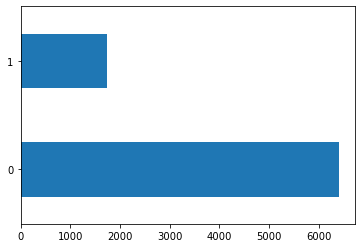

In [6]:
df.Occupancy.value_counts().plot.barh()
plt.show()

Видно, классы сильно не сбалансированны. Для оценки качества предпочтение следует отдавать PR-кривой, т.к она лучше ведет себя на несбалансированных классах.

### 4. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);

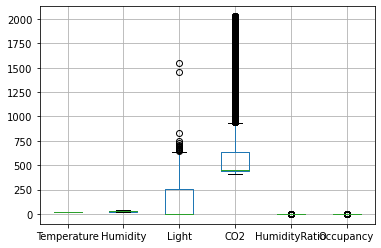

In [8]:
df.boxplot()
plt.show()

In [9]:
#Отдeлим числовые признаки
def data_normalize(df):
    numb_columns=[]
    cat_columns=[]
    for column in df.columns:
        if df[column].dtype.name!='object': numb_columns.append(column)
        else: cat_columns.append(column)
    return numb_columns, cat_columns

numb_columns, cat_columns=data_normalize(df)
#произведем нормализацию числовых признаков
scaler = preprocessing.MinMaxScaler()
df[numb_columns] = scaler.fit_transform(df[numb_columns])
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,1.000000,0.470533,0.275490,0.190933,0.557318,1.0
2,2015-02-04 17:51:59,0.992823,0.470332,0.277754,0.186446,0.554807,1.0
3,2015-02-04 17:53:00,0.992823,0.469326,0.275490,0.186136,0.553761,1.0
4,2015-02-04 17:54:00,0.992823,0.467315,0.275490,0.182887,0.551669,1.0
5,2015-02-04 17:55:00,0.980861,0.467315,0.275490,0.180566,0.547851,1.0


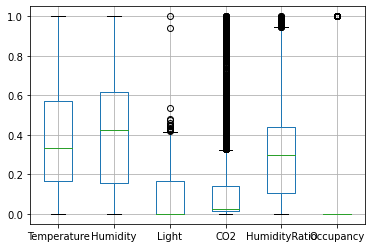

In [10]:
df.boxplot()
plt.show()

### 5. Выполните замену категориальных признаков; выберите и обоснуйте способ замены;

Категориальные признаки отсутствуют

### 6. Оцените корреляцию между признаками и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);

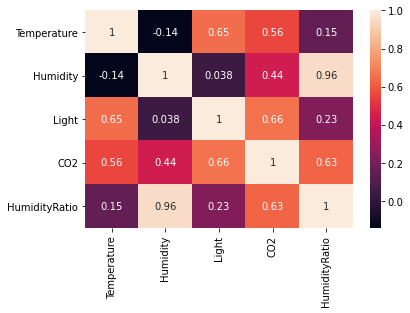

,Temperature,Humidity,Light,CO2,HumidityRatio
Temperature,1.000000,-0.141759,0.649942,0.559894,0.151762
Humidity,-0.141759,1.000000,0.037828,0.439023,0.955198
Light,0.649942,0.037828,1.000000,0.664022,0.230420
CO2,0.559894,0.439023,0.664022,1.000000,0.626556
HumidityRatio,0.151762,0.955198,0.230420,0.626556,1.000000


In [11]:
corr = df.drop('Occupancy', axis=1).corr()
sns.heatmap(corr, annot=True);
plt.show()
corr


### 7. Заполните пропущенные значения в данных;

In [12]:
df.shape

(8143, 7)

In [13]:
df.count()

date             8143
Temperature      8143
Humidity         8143
Light            8143
CO2              8143
HumidityRatio    8143
Occupancy        8143
dtype: int64

Пропущенных значений нет

### 8. Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Оцените качество работы классификатора.

In [19]:
X, Y = df[numb_columns + ['Occupancy']].drop('Occupancy', axis=1), df['Occupancy']
x_test, y_test = df_test[numb_columns + ['Occupancy']].drop('Occupancy', axis=1), df_test['Occupancy']

#### Классификатор k ближайших соседей (задается количество ближайших объектов)

In [20]:
knn = KNeighborsClassifier()
#ищем оптимальные параметры для классификатора
knn_grid = GridSearchCV(knn, dict(n_neighbors = [elem for elem in range(1,50)]))
knn_grid.fit(X, Y)
selected_n_neighbors = knn_grid.best_estimator_.n_neighbors
best_score = knn_grid.best_score_
print('best train score - ', best_score,', at neighbors number - ', selected_n_neighbors)

#создаем и тренируем модель knn по оптимальным данным
knn = KNeighborsClassifier(n_neighbors=selected_n_neighbors)
knn.fit(X, Y)
#находим процент случаев, когда классификатор дает верный результат
best_score  = np.mean(y_test  == knn.predict(x_test))
print('test score - ', best_score)

best train score -  0.9328218726008781 , at neighbors number -  44
test score -  0.9487284659557014


#### Логический классификатор (бинарное решающее дерево)

In [21]:
#ищем оптимальную глубину и количество учитываемых параметров для классификатора решающее дерево
dtc = DecisionTreeClassifier()
params = {'max_depth': list(range(1,5)), 'max_features': list(range(1,5))}

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(X, Y)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score -  {}\nat features number - {}\nat depth - {}'.format(best_score,best_features,best_depth))

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(X, Y)
best_score  = np.mean(y_test == dtc.predict(x_test))
print('test score - ', best_score)
dtc.predict(x_test)

best train score -  0.979371586553907
at features number - 4
at depth - 1
test score -  0.9934372436423298


array([1., 1., 1., ..., 1., 1., 1.])

### 9. Сравните кривые для классификаторов, указанных в задании, сделайте выводы.

Логический классификатор показал чуть лучший результат, чем классификатор k ближайших соседей